In [2]:

import cv2
from matplotlib import pyplot as plt
import pickle
with open(f"../../datasets/without_bg_revision/annotations/train/revision_data.pkl", "rb") as st_json:
    meta = pickle.load(st_json)

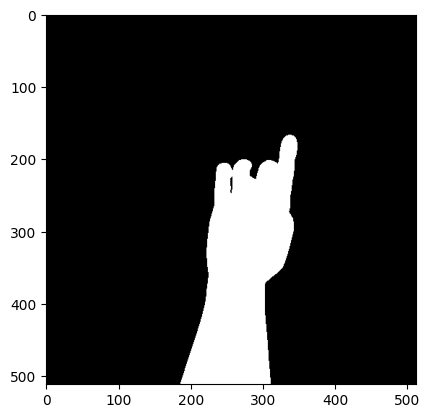

In [3]:
import numpy as np
import os
img_path = os.path.join("../../datasets/without_bg_revision/images/train")
name = '/'.join(meta[0]['file_name'].split('/')[1:])
image = cv2.imread(os.path.join(img_path, name))  # PIL image
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
index = np.where((image[:, :, 0] != 0) | (image[:, :, 1] != 0) | (image[:, :, 2] != 0))
white_img = np.ones((512, 512, 3)) * 255
image[index] = white_img[index]
plt.imshow(image)
plt.show()

In [4]:
index = np.array(index)
min_row = min(index[0])
max_row = max(index[0])
min_col = min(index[1])
max_col = max(index[1])
print()

In [5]:
def visualize_bbox(image, bbox):
    image = ((image + abs(image.min())) / (image + abs(image.min())).max()).copy()
    cv2.line(image, (int(bbox[2]), int(bbox[0])),
                (int(bbox[3]), int(bbox[0])),
                [0, 0, 1], 4)
    cv2.line(image, (int(bbox[2]), int(bbox[0])),
            (int(bbox[2]), int(bbox[1])),
            [0, 0, 1], 4)
    cv2.line(image, (int(bbox[3]), int(bbox[1])),
        (int(bbox[3]), int(bbox[0])),
        [0, 0, 1], 4)
    cv2.line(image, (int(bbox[3]), int(bbox[1])),
    (int(bbox[2]), int(bbox[1])),
    [0, 0, 1], 4)

    plt.imshow(image)
    plt.show()
    


In [6]:
def get_transform(center, scale, res, rot=0):
    """Generate transformation matrix."""
    h = res[0] * scale
    # h = 200 * scale
    t = np.zeros((3, 3))
    t[0, 0] = float(res[1]) / h
    t[1, 1] = float(res[0]) / h
    t[0, 2] = res[1] * (-float(center[0]) / h + .5)
    t[1, 2] = res[0] * (-float(center[1]) / h + .5)
    t[2, 2] = 1
    if not rot == 0:
        rot = -rot # To match direction of rotation from cropping
        rot_mat = np.zeros((3,3))
        rot_rad = rot * np.pi / 180
        sn,cs = np.sin(rot_rad), np.cos(rot_rad)
        rot_mat[0,:2] = [cs, -sn]
        rot_mat[1,:2] = [sn, cs]
        rot_mat[2,2] = 1
        # Need to rotate around center
        t_mat = np.eye(3)
        t_mat[0,2] = -res[1]/2
        t_mat[1,2] = -res[0]/2
        t_inv = t_mat.copy()
        t_inv[:2,2] *= -1
        t = np.dot(t_inv,np.dot(rot_mat,np.dot(t_mat,t)))
    return t


def transform(pt, center, scale, res, invert=0, rot=0):
    """Transform pixel location to different reference."""
    t = get_transform(center, scale, res, rot=rot)
    if invert:
        # t = np.linalg.inv(t)
        t_torch = torch.from_numpy(t)
        t_torch = torch.inverse(t_torch)
        t = t_torch.numpy()
    new_pt = np.array([pt[0]-1, pt[1]-1, 1.]).T
    new_pt = np.dot(t, new_pt)
    return new_pt[:2].astype(int)+1

def crop(img, center, scale, res, rot=0):
    """Crop image according to the supplied bounding box."""
    # Upper left point
    ul = np.array(transform([1, 1], center, scale, res, invert=1))-1
    # Bottom right point
    br = np.array(transform([res[0]+1, 
                             res[1]+1], center, scale, res, invert=1))-1
    # Padding so that when rotated proper amount of context is included
    pad = int(np.linalg.norm(br - ul) / 2 - float(br[1] - ul[1]) / 2)
    if not rot == 0:
        ul -= pad
        br += pad
    new_shape = [br[1] - ul[1], br[0] - ul[0]]
    if len(img.shape) > 2:
        new_shape += [img.shape[2]]
    new_img = np.zeros(new_shape)

    # Range to fill new array
    new_x = max(0, -ul[0]), min(br[0], len(img[0])) - ul[0]
    new_y = max(0, -ul[1]), min(br[1], len(img)) - ul[1]
    # Range to sample from original image
    old_x = max(0, ul[0]), min(len(img[0]), br[0])
    old_y = max(0, ul[1]), min(len(img), br[1])

    new_img[new_y[0]:new_y[1], new_x[0]:new_x[1]] = img[old_y[0]:old_y[1], 
                                                        old_x[0]:old_x[1]]
    if not rot == 0:
        # Remove padding
        # new_img = scipy.misc.imrotate(new_img, rot)
        new_img = myimrotate(new_img, rot)
        new_img = new_img[pad:-pad, pad:-pad]

    # new_img = scipy.misc.imresize(new_img, res)
    new_img = myimresize(new_img, [res[0], res[1]])
    return new_img


def myimrotate(img, angle, center=None, scale=1.0, border_value=0, auto_bound=False):
    if center is not None and auto_bound:
        raise ValueError('`auto_bound` conflicts with `center`')
    h, w = img.shape[:2]
    if center is None:
        center = ((w - 1) * 0.5, (h - 1) * 0.5)
    assert isinstance(center, tuple)

    matrix = cv2.getRotationMatrix2D(center, angle, scale)
    if auto_bound:
        cos = np.abs(matrix[0, 0])
        sin = np.abs(matrix[0, 1])
        new_w = h * sin + w * cos
        new_h = h * cos + w * sin
        matrix[0, 2] += (new_w - w) * 0.5
        matrix[1, 2] += (new_h - h) * 0.5
        w = int(np.round(new_w))
        h = int(np.round(new_h))
    rotated = cv2.warpAffine(img, matrix, (w, h), borderValue=border_value)
    return rotated

def myimresize(img, size, return_scale=False):

    h, w = img.shape[:2]
    resized_img = cv2.resize(
        img, (size[0],size[1]))
    if not return_scale:
        return resized_img
    else:
        w_scale = size[0] / w
        h_scale = size[1] / h
        return resized_img, w_scale, h_scale



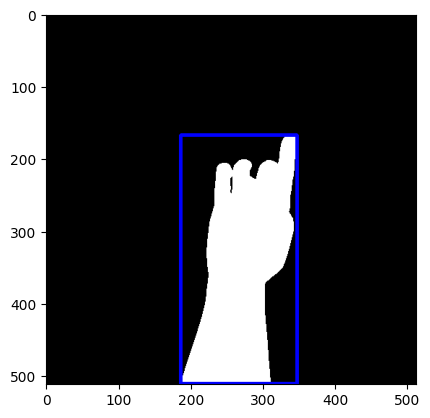

In [7]:
bbox = (min_row, max_row, min_col, max_col)
visualize_bbox(image, bbox)

In [8]:
def visualize(image, joint_2d, bbox, bbox_hand, boundary):
    image = ((image + abs(image.min())) / (image + abs(image.min())).max()).copy()
    parents = np.array([-1, 0, 1, 2, 3, 0, 5, 6, 7, 0, 9, 10, 11, 0, 13, 14, 15, 0, 17, 18, 19])
    fig = plt.figure()
    ax1 = fig.add_subplot(1, 3, 1)    

    for i in range(21):
        cv2.circle(image, (int(joint_2d[i][0]), int(joint_2d[i][1])), 2, [0, 1, 0],
                    thickness=-1)
        if i != 0:
            cv2.line(image, (int(joint_2d[i][0]), int(joint_2d[i][1])),
                        (int(joint_2d[parents[i]][0]), int(joint_2d[parents[i]][1])),
                        [0, 0, 1], 1)
            
    cv2.line(image, (int(bbox[2]), int(bbox[0])),
            (int(bbox[3]), int(bbox[0])),
            [0, 0, 1], 4)
    cv2.line(image, (int(bbox[2]), int(bbox[0])),
            (int(bbox[2]), int(bbox[1])),
            [0, 0, 1], 4)
    cv2.line(image, (int(bbox[3]), int(bbox[1])),
        (int(bbox[3]), int(bbox[0])),
        [0, 0, 1], 4)
    cv2.line(image, (int(bbox[3]), int(bbox[1])),
    (int(bbox[2]), int(bbox[1])),
    [0, 0, 1], 4)
    
    cv2.line(image, (int(bbox_hand[2]), int(bbox_hand[0])),
        (int(bbox_hand[3]), int(bbox_hand[0])),
        [1, 0 , 0], 4)
    cv2.line(image, (int(bbox_hand[2]), int(bbox_hand[0])),
            (int(bbox_hand[2]), int(bbox_hand[1])),
            [1, 0 , 0], 4)
    cv2.line(image, (int(bbox_hand[3]), int(bbox_hand[1])),
        (int(bbox_hand[3]), int(bbox_hand[0])),
        [1, 0 , 0], 4)
    cv2.line(image, (int(bbox_hand[3]), int(bbox_hand[1])),
    (int(bbox_hand[2]), int(bbox_hand[1])),
    [1, 0 , 0], 4)
    
    cv2.line(image, (int(boundary[0]), int(boundary[2])),
        (int(boundary[0]), int(boundary[3])),
        [0, 1, 0], 4)
    cv2.line(image, (int(boundary[0]), int(boundary[2])),
            (int(boundary[1]), int(boundary[2])),
            [0, 1, 0], 4)
    cv2.line(image, (int(boundary[1]), int(boundary[3])),
        (int(boundary[1]), int(boundary[2])),
        [0, 1, 0], 4)
    cv2.line(image, (int(boundary[1]), int(boundary[3])),
    (int(boundary[0]), int(boundary[3])),
    [0, 1, 0], 4)

    ax1.imshow(image)

    
    return fig

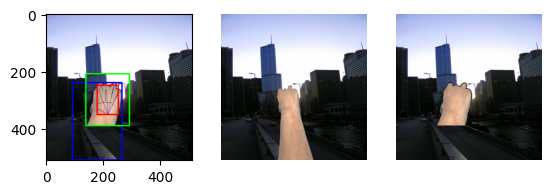

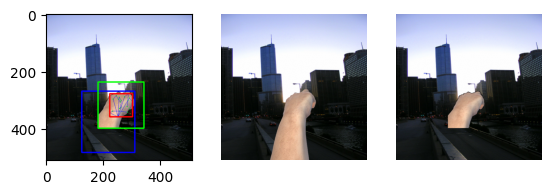

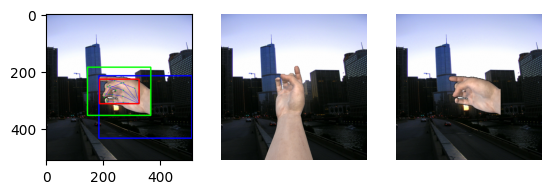

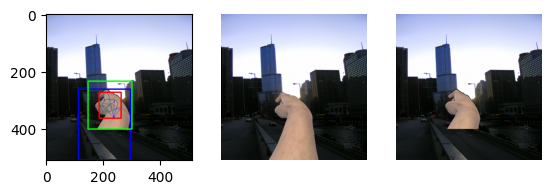

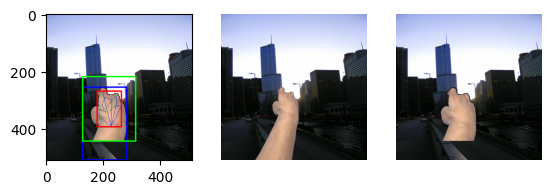

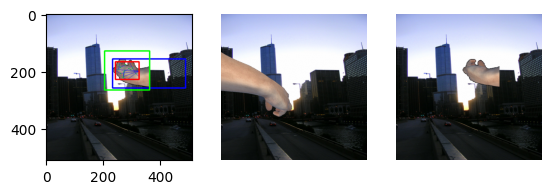

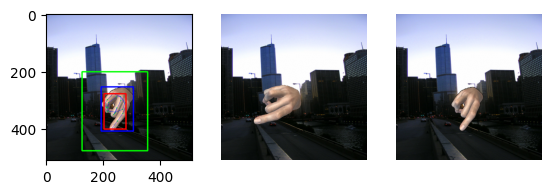

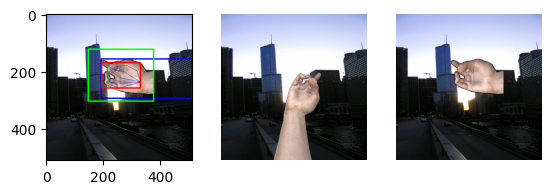

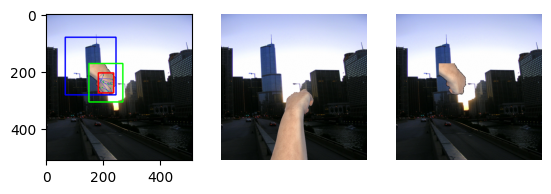

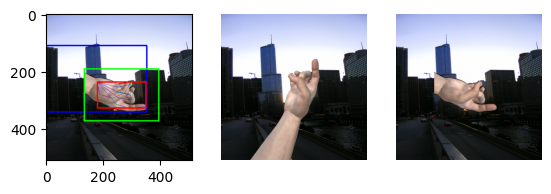

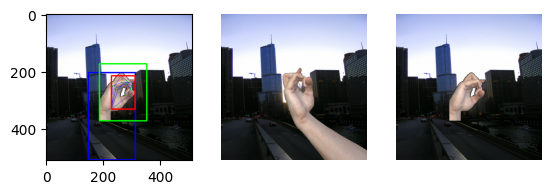

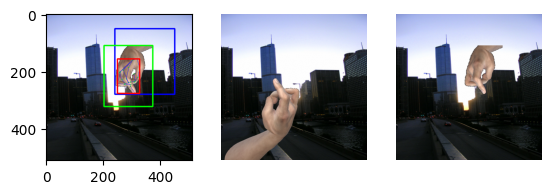

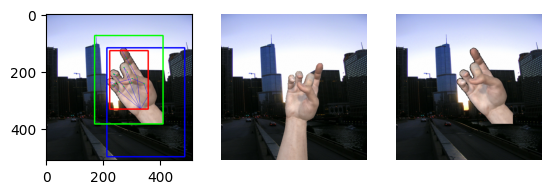

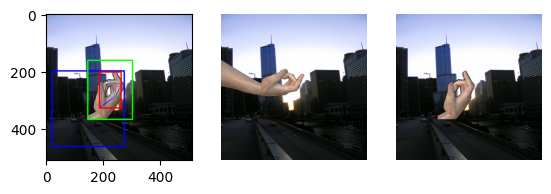

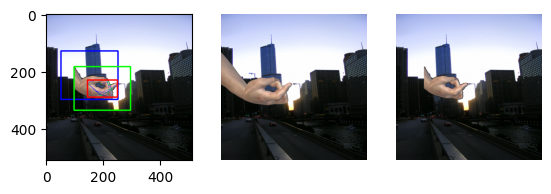

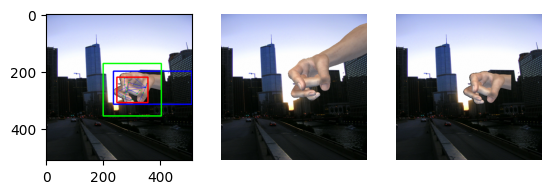

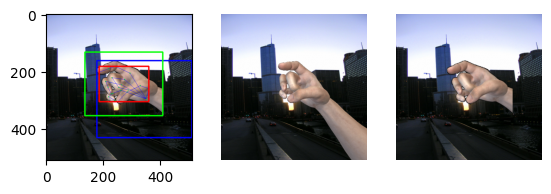

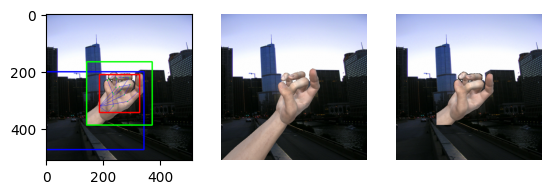

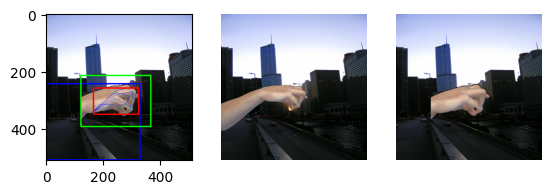

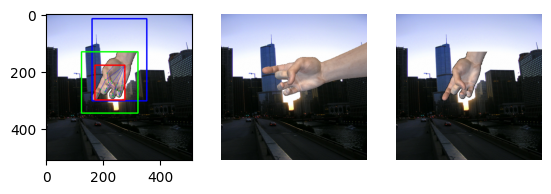

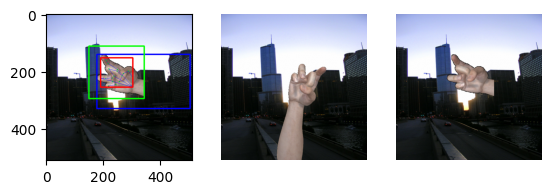

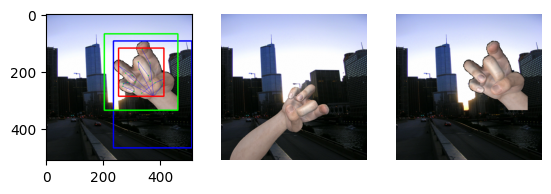

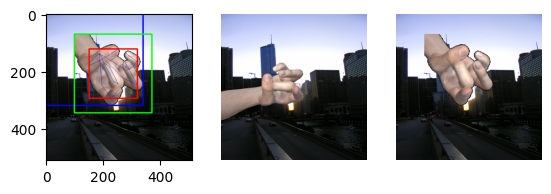

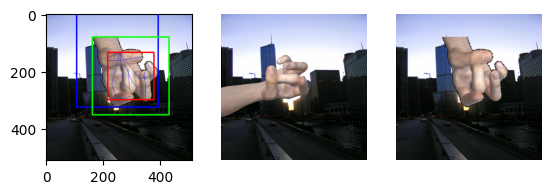

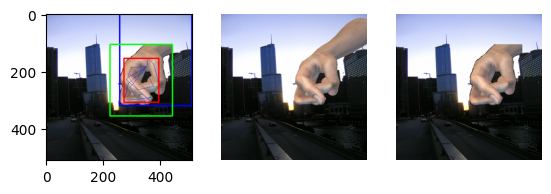

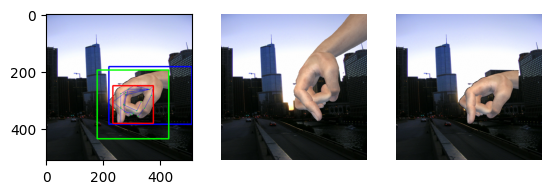

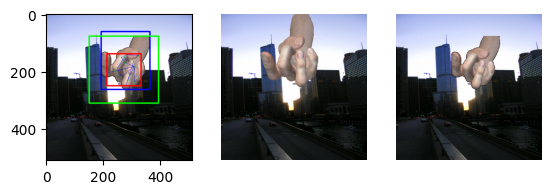

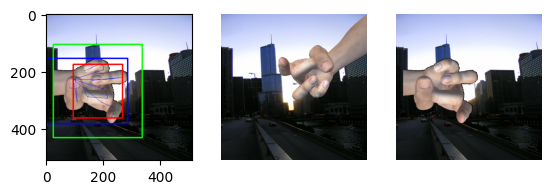

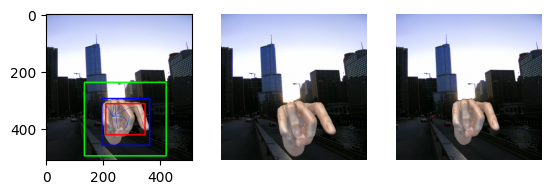

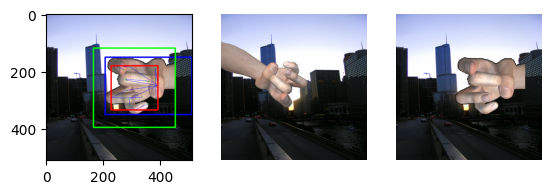

In [18]:
import torch
import os

bg_path = "../../datasets/without_bg_revision/background"
bg_list = os.listdir(bg_path)
bg_len = len(bg_list)
bg_img = cv2.imread(os.path.join(bg_path, bg_list[idx%bg_len]))
bg_img = cv2.cvtColor(bg_img, cv2.COLOR_BGR2RGB)
bg_img = cv2.resize(bg_img, (512, 512))

for idx in range(20, 50):
    name = '/'.join(meta[idx]['file_name'].split('/')[1:])
    image = cv2.imread(os.path.join(img_path, name))  # PIL image
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    joint_2d = np.array(meta[idx]['joint_2d'])
    joint_3d = meta[idx]['joint_3d']    
    scale = meta[idx]['scale']   
    rot = meta[idx]['rot']       
    cropped_img = crop(image, (512/2, 512/2), scale, [512, 512], rot=rot)    

    new_image = np.zeros((512, 512, 3))
    new_image2 = np.zeros((512, 512, 3))
    index = np.where((cropped_img[:, :, 0] != 0) | (cropped_img[:, :, 1] != 0) | (cropped_img[:, :, 2] != 0))
    index = np.array(index)
    min_row = min(index[0])
    max_row = max(index[0])
    min_col = min(index[1])
    max_col = max(index[1])
    bbox_hand = [min_row, max_row, min_col, max_col]
    bbox = [min(joint_2d[:, 1]),  max(joint_2d[:, 1]), min(joint_2d[:, 0]), max(joint_2d[:, 0])]

    dia_of_bbox = np.sqrt((min(joint_2d[:, 0]) - max(joint_2d[:, 0]))**2 + (min(joint_2d[:, 1]) - max(joint_2d[:, 1]))**2) / 512
    dia_of_hand = np.sqrt((min_row - max_row) ** 2 + (min_col - max_col) ** 2) / 512
    ratio_of_dia = dia_of_bbox / dia_of_hand
    a = int(max(bbox[0] - (ratio_of_dia * 100), 0))
    b = int(min(bbox[1] + (ratio_of_dia * 100), 512))
    c = int(max(bbox[2] - (ratio_of_dia * 100), 0))
    d = int(min(bbox[3] + (ratio_of_dia * 100), 512))
    boundary = [c, d, a, b]
    new_image[a : b, c: d] = cropped_img[a : b, c: d]
    new_image2 = image
    # visualize_bbox(image, bbox)

    index = np.where((new_image[:, :, 0] == 0) & (new_image[:, :, 1] == 0) & (new_image[:, :, 2] == 0))
    index2 = np.where((new_image2[:, :, 0] == 0) & (new_image2[:, :, 1] == 0) & (new_image2[:, :, 2] == 0))
    new_image[index] = bg_img[index]
    new_image2[index2] = bg_img[index2]


    fig = visualize(new_image, joint_2d, bbox_hand, bbox, boundary)
    ax2 = fig.add_subplot(1, 3, 2)
    ax2.imshow(new_image2 / 255)
    ax2.axis('off')
    ax3 = fig.add_subplot(1, 3, 3)
    ax3.imshow(new_image / 255)
    ax3.axis('off')
    plt.show()
